In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from neuralprophet import NeuralProphet
# from fbprophet import Prophet
# from openpyxl.workbook import Workbook
from matplotlib import pyplot as plt
from neuralprophet import NeuralProphet, set_log_level
set_log_level("ERROR")

In [2]:
m = NeuralProphet(seasonality_mode= "multiplicative", learning_rate = 0.1)

df = pd.read_csv('../forecasting/historical_data/cable_retention_monthly.csv', parse_dates=['ds'])
df.loc[(df['ds'] > '2020-02-01') & (df['ds'] < '2020-12-01'), 'y'] = None
# create a test holdout set:
df_train_val, df_test = m.split_df(df=df, freq="MS", valid_p=0.2)
# create a validation holdout set:
df_train, df_val = m.split_df(df=df_train_val, freq="MS", valid_p=0.2)

In [3]:
# fit a model on training data and evaluate on validation set.
metrics_train1 = m.fit(df=df_train, freq="MS")
metrics_val = m.test(df=df_val)


In [4]:
# refit model on training and validation data and evaluate on test set.
m = NeuralProphet(seasonality_mode= "multiplicative", learning_rate = 0.1)
metrics_train2 = m.fit(df=df_train_val, freq="MS")
metrics_test = m.test(df=df_test)

In [5]:
metrics_train1["split"]  = "train1"
metrics_train2["split"]  = "train2"
metrics_val["split"] = "validate"
metrics_test["split"] = "test"
metrics_train1.tail(1).append([metrics_train2.tail(1), metrics_val, metrics_test]).drop(columns=['RegLoss'])

,SmoothL1Loss,MAE,RMSE,split
955,0.000491,196.990868,243.515650,train1
819,0.000735,256.994982,356.552551,train2
0,0.067443,2137.164062,2857.355225,validate
0,0.006466,935.929077,1075.860840,test


In [6]:
METRICS = ['SmoothL1Loss', 'MAE', 'RMSE']
params = {"seasonality_mode": "multiplicative", "learning_rate": 0.1}

df = pd.read_csv('../forecasting/historical_data/cable_retention_monthly.csv', parse_dates=['ds'])
folds = NeuralProphet(**params).crossvalidation_split_df(df, freq="MS", k=5, fold_pct=0.20, fold_overlap_pct=0.5)

In [7]:
metrics_train = pd.DataFrame(columns=METRICS)
metrics_test = pd.DataFrame(columns=METRICS)

for df_train, df_test in folds:
    m = NeuralProphet(**params)
    train = m.fit(df=df_train, freq="MS")
    test = m.test(df=df_test)
    metrics_train = metrics_train.append(train[METRICS].iloc[-1])
    metrics_test = metrics_test.append(test[METRICS].iloc[-1])

In [8]:
metrics_test.describe()

,SmoothL1Loss,MAE,RMSE
count,5.000000,5.000000,5.000000
unique,5.000000,5.000000,5.000000
top,0.221411,2526.838867,3233.358398
freq,1.000000,1.000000,1.000000


In [9]:
metrics_val.describe()

,SmoothL1Loss,MAE,RMSE
count,1.000000,1.000000,1.000000
mean,0.067443,2137.164062,2857.355225
std,NaN,NaN,NaN
min,0.067443,2137.164062,2857.355225
25%,0.067443,2137.164062,2857.355225
50%,0.067443,2137.164062,2857.355225
75%,0.067443,2137.164062,2857.355225
max,0.067443,2137.164062,2857.355225


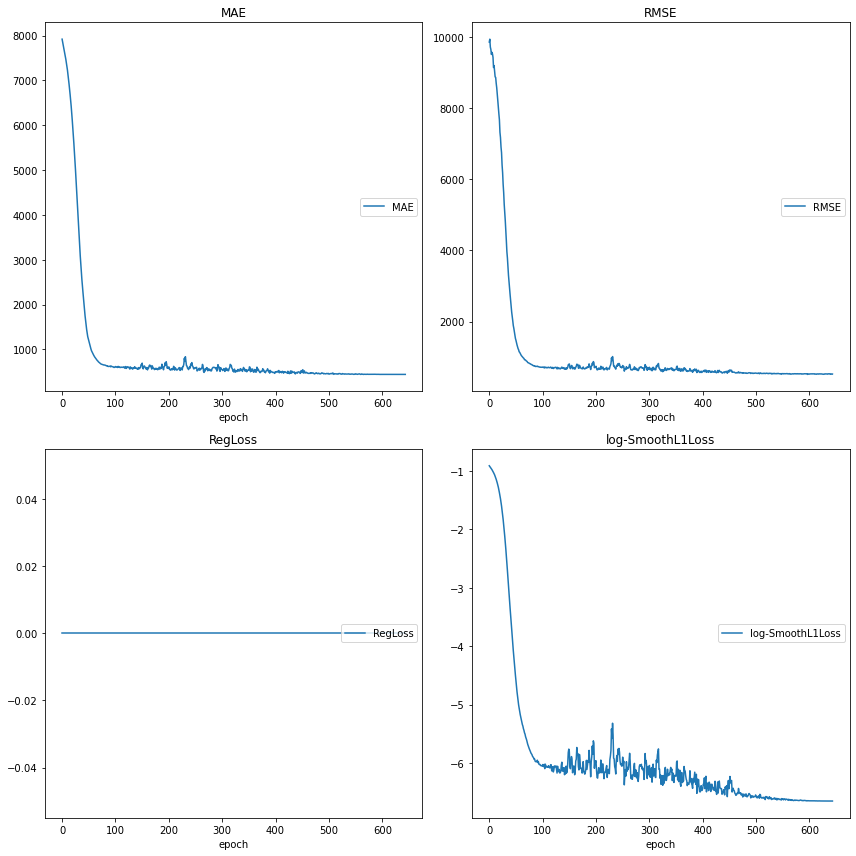

MAE
	MAE              	 (min:  440.068, max: 7920.922, cur:  440.745)
RMSE
	RMSE             	 (min:  512.804, max: 9945.562, cur:  523.560)
RegLoss
	RegLoss          	 (min:    0.000, max:    0.000, cur:    0.000)
log-SmoothL1Loss
	log-SmoothL1Loss 	 (min:   -6.649, max:   -0.914, cur:   -6.649)


In [10]:
m = NeuralProphet(growth='linear', ## Determine trend types: 'linear', 'discontinuous', 'off'
#                   changepoints=None, ## list of dates that may include change points (None -> automatic )
#                   n_changepoints=5,
#                   changepoints_range=0.8,
#                   trend_reg=0,
#                   trend_reg_threshold=False,
                  yearly_seasonality=True,
#                   weekly_seasonality=True,
#                   daily_seasonality=True,
                  seasonality_mode="additive",
#                   seasonality_reg=0,
#                   n_forecasts=1,
#                   n_lags=0,
#                   num_hidden_layers=0,
#                   d_hidden=None,     # Dimension of hidden layers of AR-Net
#                   ar_reg=None,
#                   learning_rate=None,
#                   epochs=None,
#                   batch_size=None,
#                   loss_func="Huber",
#                   optimizer="AdamW",
#                   normalize="auto",  # Type of normalization ('minmax', 'standardize', 'soft', 'off')
#                   impute_missing=True,
                  newer_samples_weight=1.0)
metrics = m.fit(df,progress='plot-all')

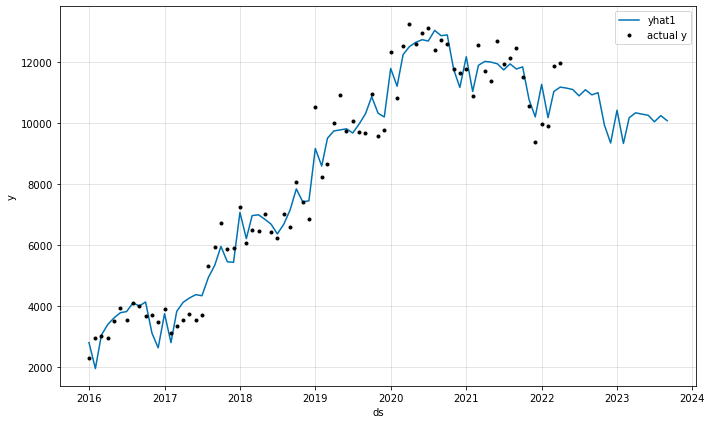

In [11]:
future = m.make_future_dataframe(df, periods=17, n_historic_predictions=len(df))
forecast = m.predict(future)
fig = m.plot(forecast)

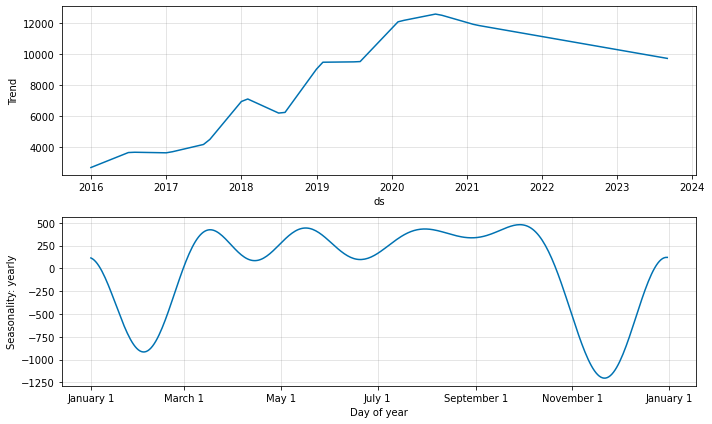

In [12]:
fig_comp = m.plot_components(forecast)


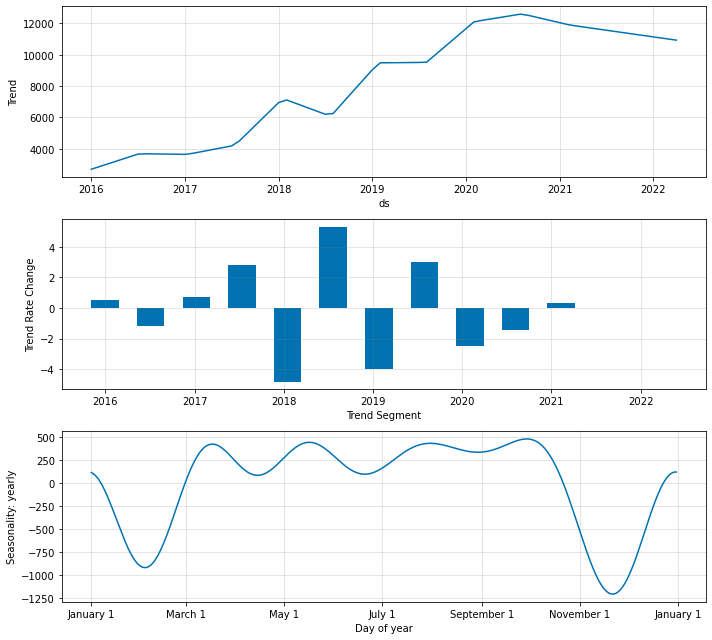

In [13]:
fig_param = m.plot_parameters()

In [14]:
forecast.to_excel('outputs/cable_sales_nn_cv.xlsx')